# 1D NLSE Solver

The goal of this notebook is to solve the Nonlinear Shrodinger Equation in 1D:
\begin{equation}
    \frac{\partial A}{\partial z} = -i\frac{\beta_2}{2} \frac{\partial^2 A}{\partial t^2} + i\gamma |A|^2 A.
\end{equation}
The first term of RHS corresponds to the chromatic dispersion, where $\beta_2$ is group velocity dispersion, and the second term is Kerr nonlinearity. 

This can be solved numerically using split-step Fourier method:
\begin{equation}
    A(z + \Delta z, T) = \mathcal{F}^{-1}\left\{ e^{i\frac{\beta_2}{2} (\omega)^2 \Delta z}  \cdot   \mathcal{F} \left\{   e^{i \gamma |A(z, T)|^2 \Delta z}   A(z, T) \right\}  \right\} 
\end{equation}

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size': 14})

def dispersion_operator(beta2, dt, Nt, dz):
    """Calculate the dispersion operator for the linear step in Fourier space."""
    omega = 2 * np.pi * np.fft.fftfreq(Nt, dt)
    return np.exp(0.5j * beta2 * omega**2 * dz)

def nonlinear_operator(gamma, A, dz):
    """Apply the nonlinear operator for the nonlinear step in real space."""
    return A * np.exp(1j * gamma * np.abs(A)**2 * dz) # apply the operator to the pulse (time-list of A)

def split_step_fourier(A0, dz, Nz, beta2, gamma):
    """Implement the Split-Step Fourier Method."""
    A = A0.copy()
    Nt = len(A)
    dt = Lt / Nt
    linear_op = dispersion_operator(beta2, dt, Nt, dz)
    A_evolution = np.zeros((Nt, Nz+1), dtype=complex)
    A_evolution[:, 0] = A0 # set first row of A_evolution to be the initial pulse
    
    for i in range(Nz):
        A = nonlinear_operator(gamma, A, dz) # apply nonlinear operator
        A_ft = np.fft.fft(A) # transform to Fourier space
        A_ft *= linear_op # apply linear operator
        A = np.fft.ifft(A_ft) # transform back to real space
        A_evolution[:, i+1] = A

    return A_evolution

def plot_intensity_evolution(intensity_evolution, t, Lz, Nz):
    """Plot the intensity evolution in 3D."""
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    T, Z = np.meshgrid(t, np.linspace(0, Lz, Nz+1))
    
    # print shape
    print('Shape of T:', T.shape)
    print('Shape of Z:', Z.shape)
    print('Shape of intensity_evolution:', intensity_evolution.shape)
    print(T[10,:])
    # print datatypes
    print('Datatype of T:', T.dtype)
    print('Datatype of Z:', Z.dtype)
    print('Datatype of intensity_evolution:', intensity_evolution.dtype)
    
    
    
    surf = ax.plot_surface(T, Z, intensity_evolution.T, cmap='viridis', edgecolor='none') # intensity_evolution.T is the intensity matrix (transposed to match dimensions) - Z value
    ax.set_xlabel('Time (ps)')
    ax.set_ylabel('z (km)')
    ax.set_zlabel('Intensity |A|^2')
    ax.set_title('Intensity Evolution in NLSE')
    plt.show()

def plot_temporal_waveform(z_plot_list, A_evolution):
    plt.figure(figsize=(10, 5))
    for z_plot in z_plot_list: 
        index = int(z_plot/Lz * Nz)
        plt.plot(t, np.abs(A_evolution[:,index])**2,label='z= %.f' %(z_plot))
    plt.title('Intensity Waveform')
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()

## Gaussian Pulse

First, consider a simple example of a Gaussian pulse, with the incident field of the form
\begin{equation}
    A(z,0) = \sqrt{P_0} e^{ - t^2/2 T_0^2},
\end{equation}
where $P_0$ is the peak power, $T_0$ is the width of the incident pulse.

Shape of T: (1001, 1024)
Shape of Z: (1001, 1024)
Shape of intensity_evolution: (1024, 1001)
[0.00000000e+00 2.93255132e-01 5.86510264e-01 ... 2.99413490e+02
 2.99706745e+02 3.00000000e+02]
Datatype of T: float64
Datatype of Z: float64
Datatype of intensity_evolution: float64


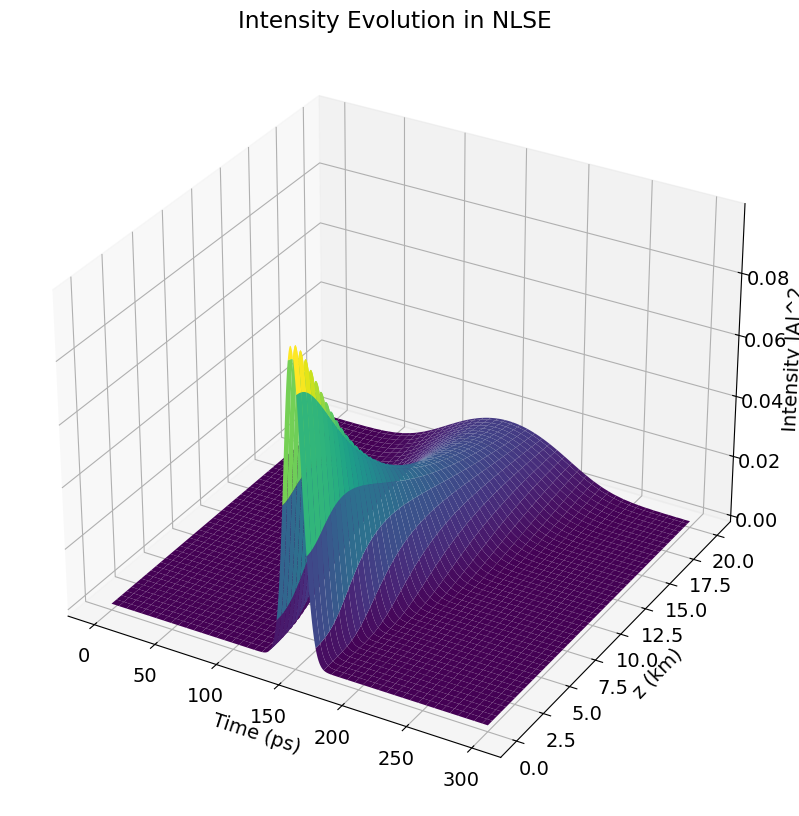

In [12]:
def gaussian_pulse(t, center, T0, P0):
    """Generate a Gaussian pulse."""
    return np.sqrt(P0) * np.exp(-((t - center) ** 2) / (2 * T0 ** 2))

# Parameters
Lz = 20.0               # Propagation distance in km
Nz = 1000               # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 300.0               # Temporal window size
Nt = 1024               # Number of temporal points
t = np.linspace(0, Lt, Nt)  # Temporal grid (only positive times)
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
P0 = 0.1                # sqrt of the peak power of the Gaussian pulse

beta2 = 20           # Dispersion coefficient in ps^2/km
gamma = 2          # Nonlinearity coefficient in W^-1 km^-1

# Initial condition
A0 = gaussian_pulse(t, center, T0, P0)

# Perform the split-step Fourier method
A_evolution = split_step_fourier(A0, dz, Nz, beta2, gamma)
intensity_evolution = np.abs( A_evolution )**2

#phase_evolution  = np.angle( A_evolution )

# Plot the intensity evolution
plot_intensity_evolution(intensity_evolution, t, Lz, Nz)

We introduce two length scales: 
1. **Dispersion length**:
\begin{equation}
    L_D = \frac{T_0^2}{|\beta_2|},
\end{equation}
where $T_0$ is the width of input pulses. 

2. **Nonlinear length**:
\begin{equation}
    L_{NL} = \frac{1}{\gamma P_0},
\end{equation}
where $P_0$ is the peak power of the incident pulse.

Those are the propagation length scales for which the effects of dispersion and nonlinear term become important.



In [3]:
L_D = T0**2 / abs(beta2)  
L_NL = 1 / (gamma*P0)
print('dispersion length = %.5f km' %(L_D))
print('nonlinear length = %.5f km' %(L_NL))

dispersion length = 5.00000 km
nonlinear length = 5.00000 km


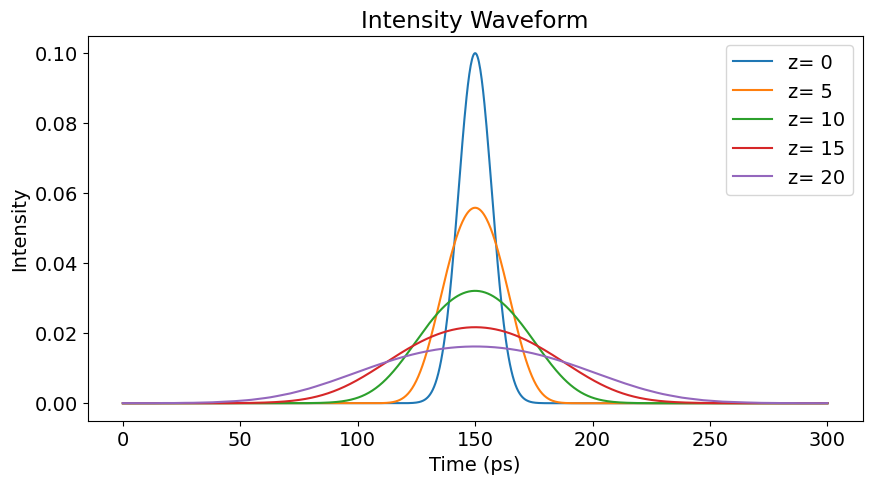

In [4]:
def plot_temporal_waveform(z_plot_list, Intensity_evolution):
    plt.figure(figsize=(10, 5))
    for z_plot in z_plot_list: 
        index = int(z_plot/Lz * Nz)
        plt.plot(t, Intensity_evolution[:,index],label='z= %.f' %(z_plot))
    plt.title('Intensity Waveform')
    plt.xlabel('Time (ps)')
    plt.ylabel('Intensity')
    plt.legend()

z_plot_list = [0,5,10,15,20]
plot_temporal_waveform(z_plot_list,intensity_evolution)

### Test 1
Without the nonlinear term, the Gaussin pulse maintains its shape on propagation but its width $T_1$ increases with $z$ as
\begin{equation}
    T_1(z) = T_0 [1+(\frac{z}{L_D})^2]^{1/2},
\end{equation}
where $T_0$ is the width of the initial pulse, the dispersion length $L_D = T_0^2/|\beta_2|$. The amplitude **of the central peak** decreases with $z$ as 
\begin{equation}
    P_1(z) = \frac{P_0} {[1+(\frac{z}{L_D})^2]^{1/2}},
\end{equation}
where $P_0$ is the peak of the initial pulse. [from Govind Chapter 3.2.3]

Let's now test whether our numerial results agree with the theoretical prediction.

dispersion length = 5.00000 km


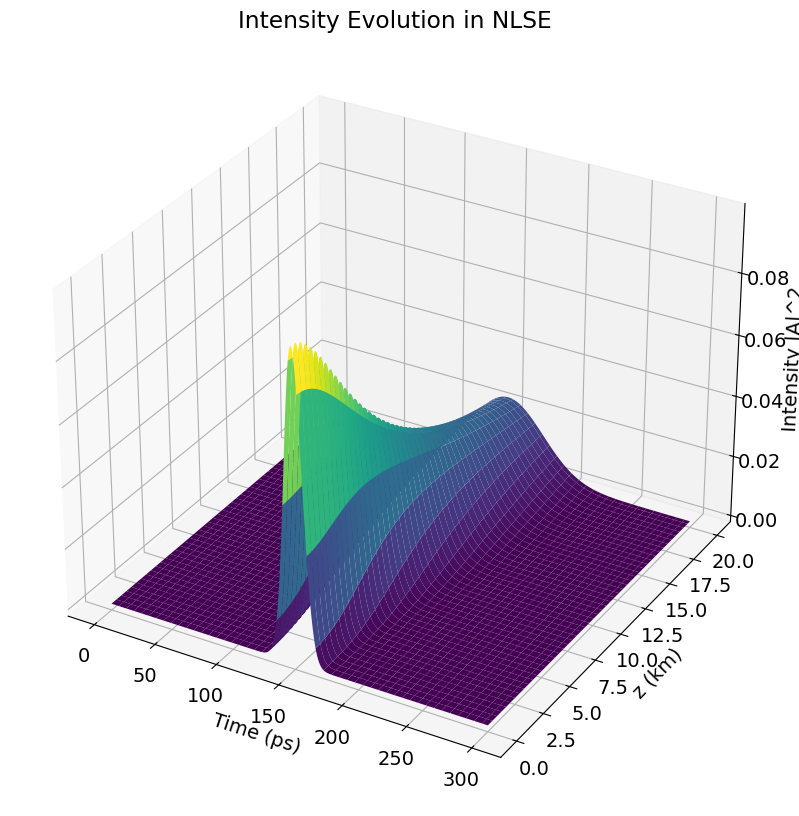

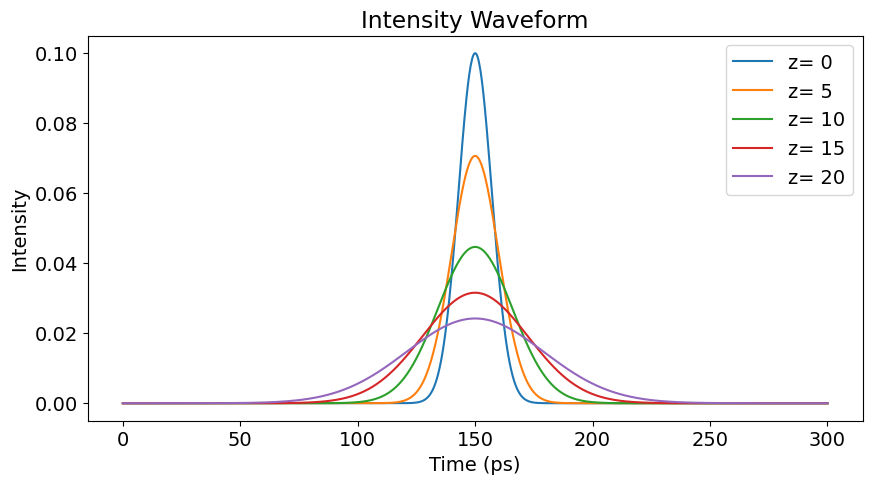

In [5]:
# Parameters
Lz = 20.0               # Propagation distance in km
Nz = 1000               # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 300.0               # Temporal window size
Nt = 1024               # Number of temporal points
t = np.linspace(0, Lt, Nt)  # Temporal grid (only positive times)
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
P0 = 0.1

beta2 = 20           # Dispersion coefficient in ps^2/km
gamma = 0          # Nonlinearity coefficient in W^-1 km^-1

L_D = T0**2 / abs(beta2)  
print('dispersion length = %.5f km' %(L_D))

# Initial condition
A0 = gaussian_pulse(t, center, T0 ,P0)

# Perform the split-step Fourier method
A_evolution = split_step_fourier(A0, dz, Nz, beta2, gamma)
intensity_evolution = np.abs( A_evolution )**2
#phase_evolution  = np.angle( A_evolution )

# Plot the intensity evolution
plot_intensity_evolution(intensity_evolution, t, Lz, Nz)
z_plot_list = [0,5,10,15,20]
plot_temporal_waveform(z_plot_list,intensity_evolution)

C:\Users\lukas\AppData\Local\Temp\ipykernel_27052\3040132788.py:2: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(amplitude) * np.exp(-((x - mean)**2 / (2 * sigma**2)))


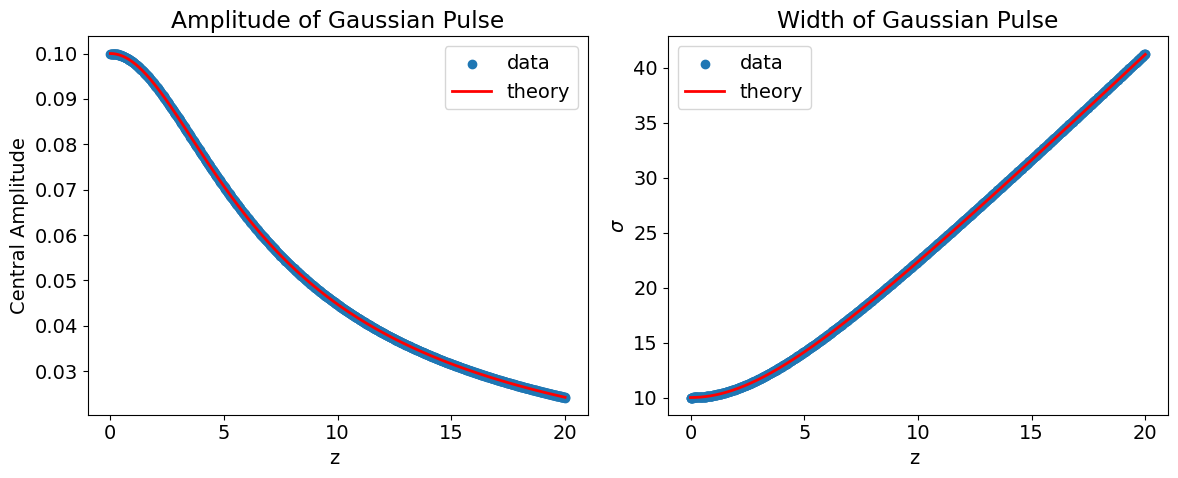

In [6]:
def gaussian(x, amplitude, mean, sigma):
    return np.sqrt(amplitude) * np.exp(-((x - mean)**2 / (2 * sigma**2)))

def theoretical_width(T0,L_D,z):
    Tz = T0 * np.sqrt( 1+ (z/L_D)**2 )
    return Tz

def theoretical_amplitude(P0,L_D,z):
    Tz = P0 / np.sqrt( 1+ (z/L_D)**2 )
    return Tz

sigma_list = []
amplitude_list = []
for i in range(Nz+1):
    # Perform the curve fit
    params, covariance = curve_fit(gaussian, t, np.abs(A_evolution[:,i]), p0=[np.sqrt(P0), center, T0])
    # Extract the amplitude, mean, and sigma from the fit parameters
    amplitude_fit, mean_fit, sigma_fit = params
    sigma_list.append( sigma_fit )
    amplitude_list.append( amplitude_fit )

z = np.linspace(0, Lz, Nz+1)

theory_width = theoretical_width(T0,L_D, z)
theory_height = theoretical_amplitude(P0,L_D, z)

plt.figure(figsize=(12, 5))

# Plot the initial waveform intensity
plt.subplot(1, 2, 1)
plt.scatter(z, amplitude_list ,label='data')
plt.plot( z, theory_height, c='r', linewidth=2,label = 'theory')
plt.title('Amplitude of Gaussian Pulse')
plt.xlabel('z ')
plt.ylabel('Central Amplitude')
plt.legend()

# Plot the final waveform intensity
plt.subplot(1, 2, 2)
plt.scatter(z, sigma_list, label='data')
plt.plot( z, theory_width, c='r', linewidth=2,label = 'theory')
plt.title('Width of Gaussian Pulse')
plt.xlabel('z ')
plt.ylabel('$\sigma$')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### Test 2: Soliton

When $\beta_2<0$, the effects from dispersion term and nonlinear term can cancel out, preseving the shape of the propgating pulse.

The fundamental soliton pulse has the sech shape
\begin{equation}
    A_s(z,t) = A_0 sech( \frac{t}{t_0} ) e^{-i\frac{\beta_2}{2t_0^2} z}.
\end{equation}

In order to have a soliton, we need to ensure the effects from nonlinear term and the dispersion term balance out exactly, satisfying
\begin{equation}
    \gamma = - \frac{\beta_2}{t_0^2 A_0^2}.
\end{equation}


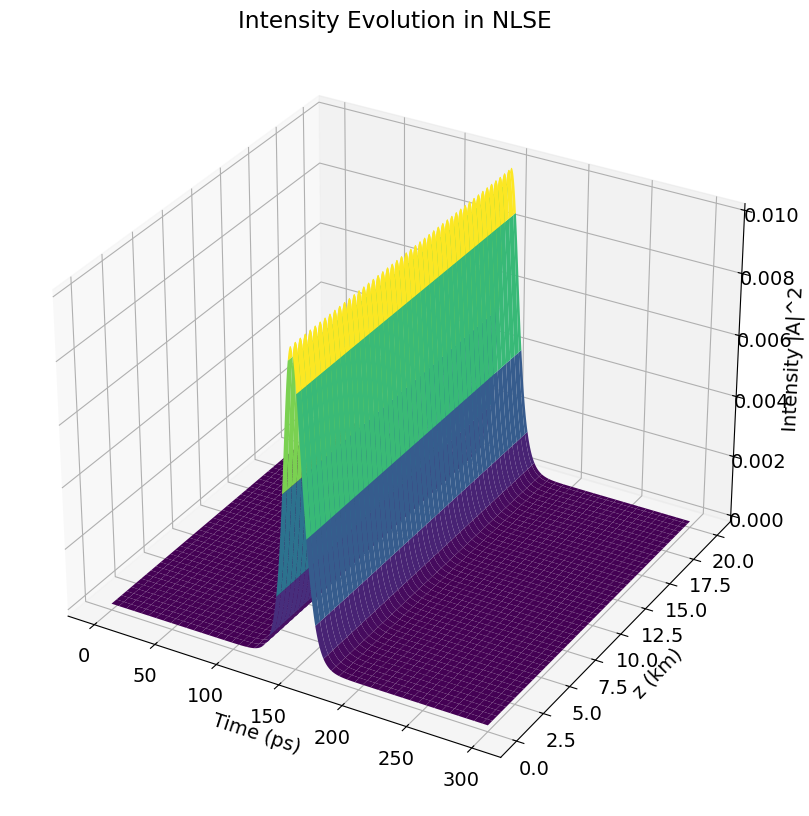

c:\Users\lukas\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\lukas\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


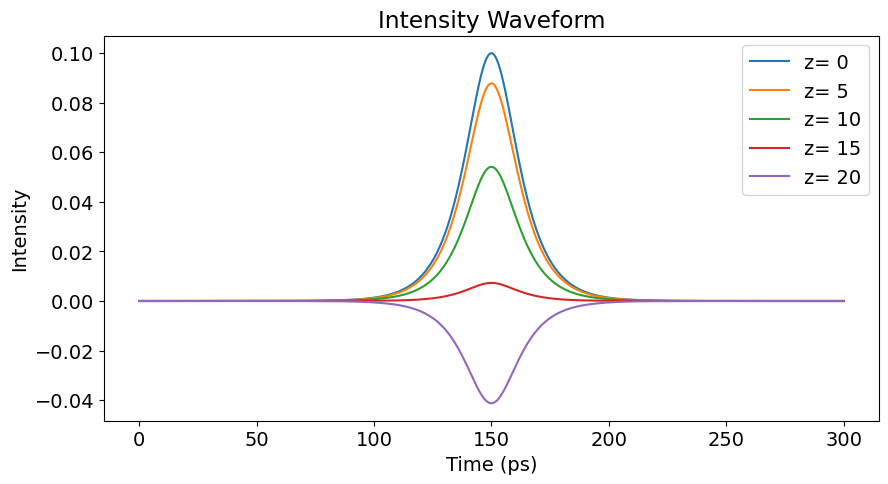

In [7]:
def sech_pulse(t, center, T0, A0):
    """Generate a Gaussian pulse."""
    return A0* 1/np.cosh( (t-center)/T0 )

# Parameters
Lz = 20.0               # Propagation distance in km
Nz = 1000               # Number of steps in z
dz = Lz / Nz            # Step size in z
Lt = 300.0               # Temporal window size
Nt = 1024               # Number of temporal points
t = np.linspace(0, Lt, Nt)  # Temporal grid (only positive times)
center = Lt / 2         # Center of the Gaussian pulse
T0 = 10.0             # Width of the Gaussian pulse on ps
A0 = 0.1                # sqrt of the peak power of the Gaussian pulse

beta2 = -20           # Dispersion coefficient in ps^2/km
gamma = -beta2 / (T0**2*A0**2)         # Nonlinearity coefficient in W^-1 km^-1

# Initial condition
A0 = sech_pulse(t, center, T0, A0)

# Perform the split-step Fourier method
A_evolution = split_step_fourier(A0, dz, Nz, beta2, gamma)
intensity_evolution = np.abs( A_evolution )**2
#phase_evolution  = np.angle( A_evolution )

# Plot the intensity evolution
plot_intensity_evolution(intensity_evolution, t, Lz, Nz)

z_plot_list = [0,5,10,15,20]
plot_temporal_waveform(z_plot_list,A_evolution)